In [1]:
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier

# some PCA and GMM stuff
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

import sklearn.ensemble as ske
from sklearn.feature_selection import SelectFromModel

In [2]:
#train_file = 'https://people.ischool.berkeley.edu/~andrew.morris/data/w209/train.csv'
#test_file = 'https://people.ischool.berkeley.edu/~andrew.morris/data/w209/test.csv'
#train_file = 'data/mini_train.csv'
train_file = 'data/train.csv'

#dev_file = 'data/mini_dev.csv'
#test_file = 'data/test.csv'

In [3]:
dtypes = {
        'MachineIdentifier':                                    'str',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float32',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int16',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float64', 
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float32', 
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float32', 
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float64', 
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float64', 
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32', 
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32', 
        'Census_InternalPrimaryDisplayResolutionVertical':      'float32', 
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float64', 
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [4]:
train_df = pd.read_csv(train_file, dtype=dtypes)
#test_df = pd.read_csv(test_file, dtype=dtypes)

In [5]:
train_labels = train_df['HasDetections']
train_ids = train_df['MachineIdentifier']
train_data = train_df.drop(columns=['HasDetections', 'MachineIdentifier'])

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 81 columns):
ProductName                                          category
EngineVersion                                        category
AppVersion                                           category
AvSigVersion                                         category
IsBeta                                               int8
RtpStateBitfield                                     float16
IsSxsPassiveMode                                     int8
DefaultBrowsersIdentifier                            float32
AVProductStatesIdentifier                            float32
AVProductsInstalled                                  float16
AVProductsEnabled                                    float16
HasTpm                                               int8
CountryIdentifier                                    int16
CityIdentifier                                       float32
OrganizationIdentifier                  

In [7]:
#test_ids = test_df['MachineIdentifier']
#test_data = test_df.drop(columns=['MachineIdentifier'])

In [8]:
#test_data.info()

In [9]:
#all_data = pd.concat((test_data,train_data), axis=0)

In [10]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = [c for c,v in dtypes.items() if v in numerics and c in train_data.columns]

In [11]:
binary_cols = [c for c in train_data.columns if train_data[c].nunique() == 2]

In [12]:
nominal_cols = [c for c in train_data.columns if (c not in numeric_cols)]

In [13]:
# Encode nominal variables as labeled strings
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for i, col in enumerate(nominal_cols):
    train_data[col] = encoder.fit_transform(train_data[col].astype(str))
    #test_data[col] = encoder.fit_transform(test_data[col].astype(str))

In [14]:
# Additional encoding TBD
print("Columns to review NaN values:")
train_data.isna().any()[lambda x: x]

# Andrew's temporary draft for StandardScaler.  Pasting in Kevin's variation, as well:

#inverse_cols = [i for i in train_data.columns if i not in numeric_cols]
#features = train_data[numeric_cols]
#ct = ColumnTransformer([('transform', StandardScaler(), numeric_cols)], remainder='passthrough')
#ct.fit_transform(features)
#train_data_scaled = pd.DataFrame(features, index=train_data.index, columns=numeric_cols)
#inverse_data = pd.DataFrame(train_data[inverse_cols], index=train_data.index, columns=inverse_cols)
#frames = [train_data_scaled, inverse_data]
#train_data2 = pd.concat(frames, sort=False)
#train_data2.describe()

# Kevin's version:
#for i, col in enumerate(numeric_cols):
#    standard_scaler = StandardScaler().fit(train_data[col])
#    train_data[col] = standard_scaler.transform(train_data[col])



Columns to review NaN values:


RtpStateBitfield                                     True
DefaultBrowsersIdentifier                            True
AVProductStatesIdentifier                            True
AVProductsInstalled                                  True
AVProductsEnabled                                    True
CityIdentifier                                       True
OrganizationIdentifier                               True
GeoNameIdentifier                                    True
IsProtected                                          True
SMode                                                True
IeVerIdentifier                                      True
Firewall                                             True
UacLuaenable                                         True
Census_OEMNameIdentifier                             True
Census_OEMModelIdentifier                            True
Census_ProcessorCoreCount                            True
Census_ProcessorManufacturerIdentifier               True
Census_Process

In [15]:
# Let's get a feeling for range of values in the nominal categories
# todo: graph their histograms

In [16]:
for i, col in enumerate(nominal_cols):
    print('The number of values for {:} = {:}'.format(col, (len(list(train_data[col].unique())))))

The number of values for ProductName = 6
The number of values for EngineVersion = 70
The number of values for AppVersion = 110
The number of values for AvSigVersion = 8531
The number of values for Platform = 4
The number of values for Processor = 3
The number of values for OsVer = 58
The number of values for OsPlatformSubRelease = 9
The number of values for OsBuildLab = 664
The number of values for SkuEdition = 8
The number of values for PuaMode = 3
The number of values for SmartScreen = 22
The number of values for Census_MDC2FormFactor = 13
The number of values for Census_DeviceFamily = 3
The number of values for Census_ProcessorClass = 4
The number of values for Census_PrimaryDiskTypeName = 5
The number of values for Census_ChassisTypeName = 53
The number of values for Census_PowerPlatformRoleName = 11
The number of values for Census_InternalBatteryType = 79
The number of values for Census_OSVersion = 469
The number of values for Census_OSArchitecture = 3
The number of values for Cen

In [17]:
for i, col in enumerate(nominal_cols):
    corr = train_labels.corr(train_data[col])
    if(corr > 0.05  or corr < -0.05):
        star='(*)' # flag the highly correlated nominal variables
    else:
        star=''
    print('The correlation of {:} with the outcome variable is {:7.6f}{:}'.format(col, corr, star))

The correlation of ProductName with the outcome variable is 0.003182
The correlation of EngineVersion with the outcome variable is 0.052190(*)
The correlation of AppVersion with the outcome variable is 0.025905
The correlation of AvSigVersion with the outcome variable is 0.054166(*)
The correlation of Platform with the outcome variable is -0.000284
The correlation of Processor with the outcome variable is -0.073186(*)
The correlation of OsVer with the outcome variable is 0.000414
The correlation of OsPlatformSubRelease with the outcome variable is 0.018257
The correlation of OsBuildLab with the outcome variable is 0.016147
The correlation of SkuEdition with the outcome variable is 0.017545
The correlation of PuaMode with the outcome variable is 0.007595
The correlation of SmartScreen with the outcome variable is -0.183976(*)
The correlation of Census_MDC2FormFactor with the outcome variable is -0.009723
The correlation of Census_DeviceFamily with the outcome variable is -0.012078
The c

In [18]:
for i, col in enumerate(numeric_cols):
    corr = train_labels.corr(train_data[col])
    if(corr > 0.05  or corr < -0.05):
        star='(*)' # flag the highly correlated numeric variables
    else:
        star=''
    print('The correlation of {:} with the outcome variable is {:7.6f}{:}'.format(col, corr, star))

The correlation of IsBeta with the outcome variable is -0.000040
The correlation of RtpStateBitfield with the outcome variable is 0.041486
The correlation of IsSxsPassiveMode with the outcome variable is -0.035066
The correlation of DefaultBrowsersIdentifier with the outcome variable is -0.002023
The correlation of AVProductStatesIdentifier with the outcome variable is 0.117404(*)
The correlation of AVProductsInstalled with the outcome variable is -0.149626(*)
The correlation of AVProductsEnabled with the outcome variable is -0.041985
The correlation of HasTpm with the outcome variable is 0.005490
The correlation of CountryIdentifier with the outcome variable is 0.007099
The correlation of CityIdentifier with the outcome variable is -0.002282
The correlation of OrganizationIdentifier with the outcome variable is 0.003243
The correlation of GeoNameIdentifier with the outcome variable is 0.003975
The correlation of LocaleEnglishNameIdentifier with the outcome variable is 0.015575
The cor

In [19]:
correlated_cols =['EngineVersion','AvSigVersion','Processor','SmartScreen',
                   'Census_OSArchitecture','AVProductStatesIdentifier',
                   'AVProductsInstalled','IsProtected','Census_IsVirtualDevice',
                   'Census_IsAlwaysOnAlwaysConnectedCapable','Wdft_IsGamer']

In [20]:
# Impute missing values

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

train_data_corr = train_data[correlated_cols]
#train_data_corr = train_data
imputer.fit(train_data_corr)
train_data_corr = imputer.transform(train_data_corr)


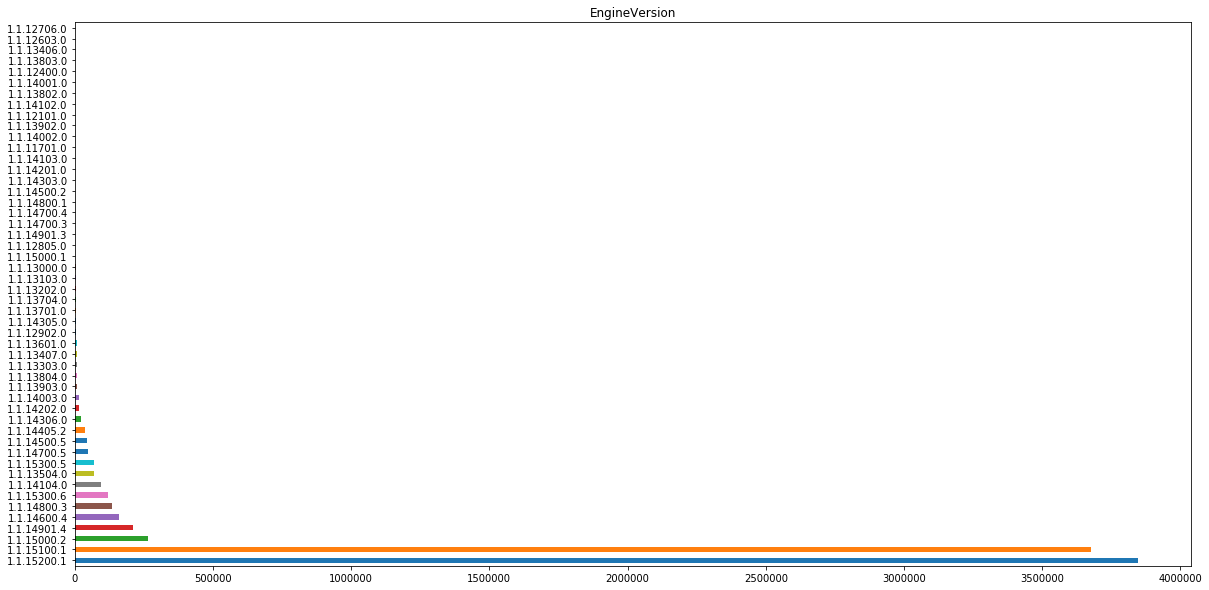

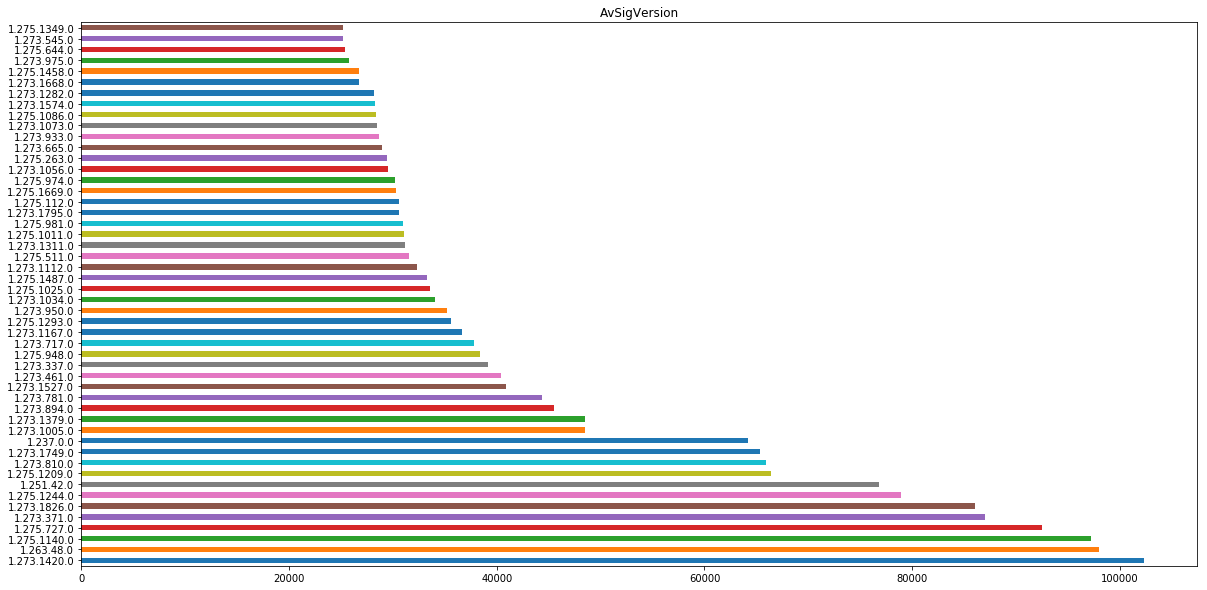

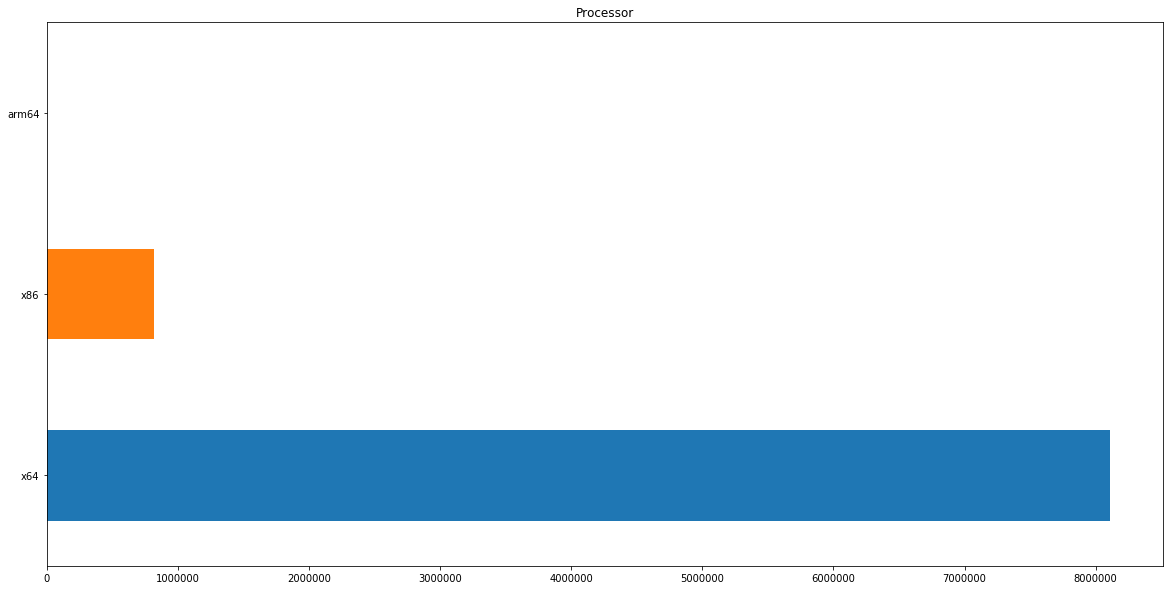

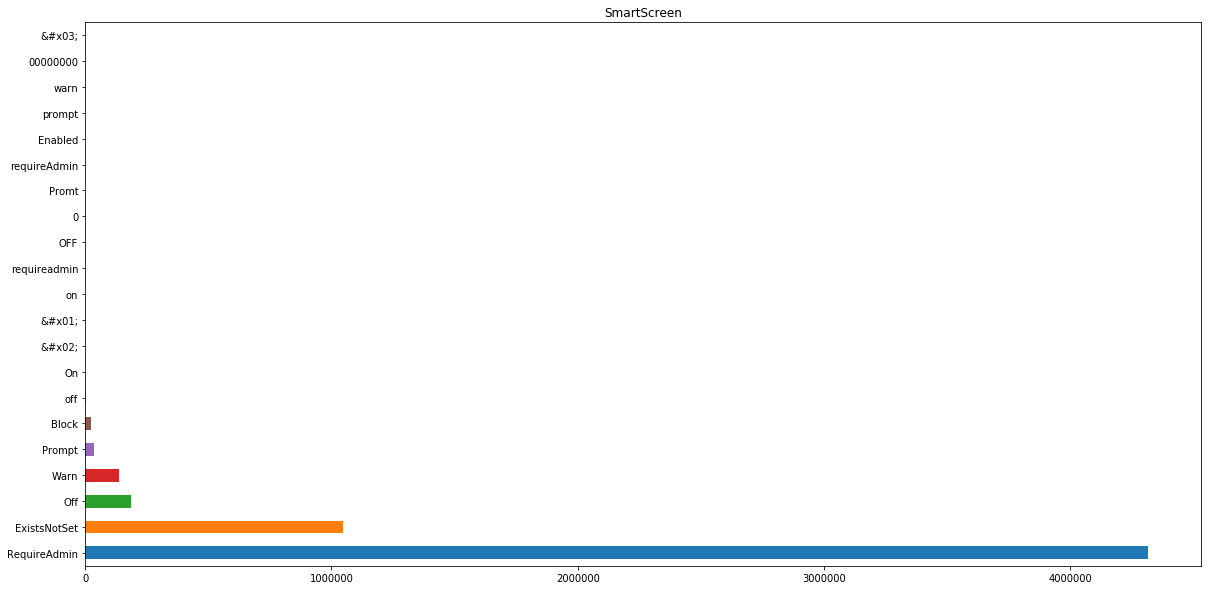

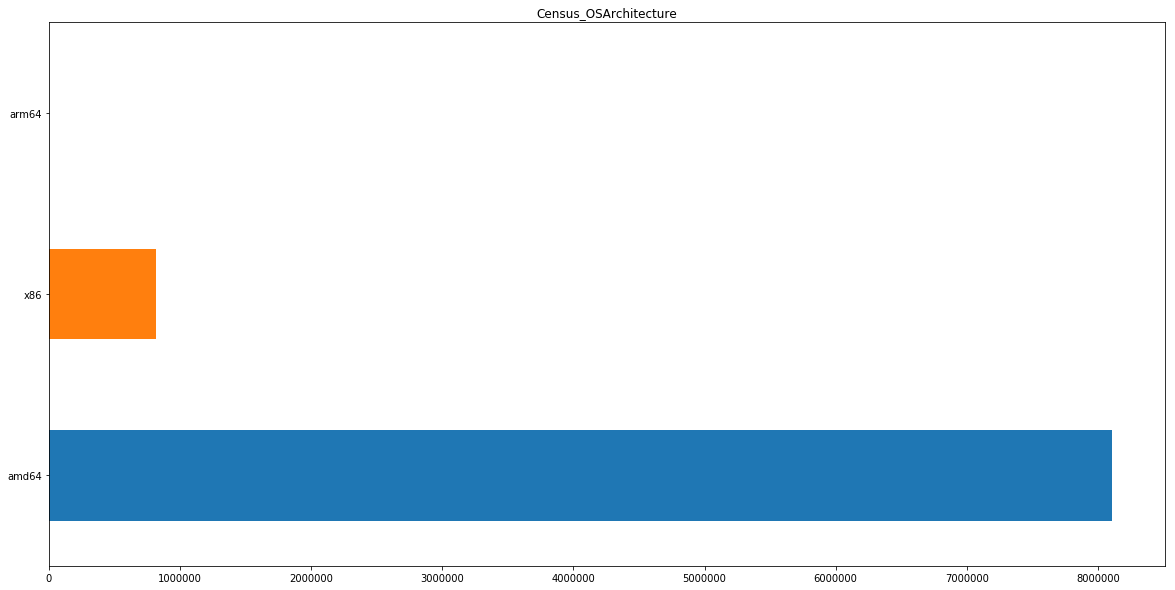

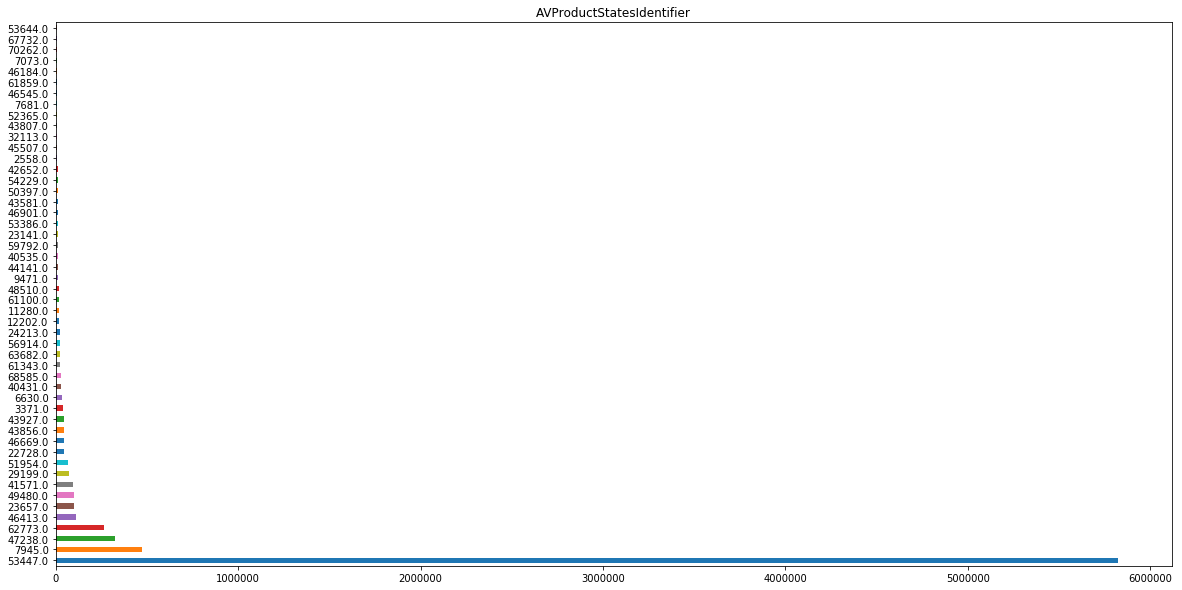

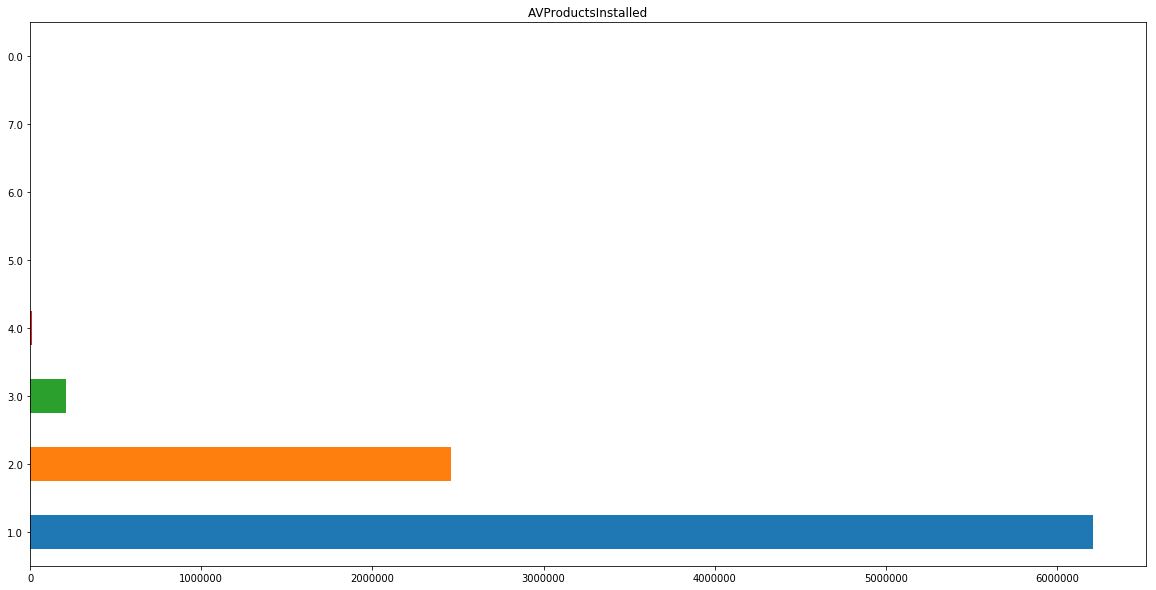

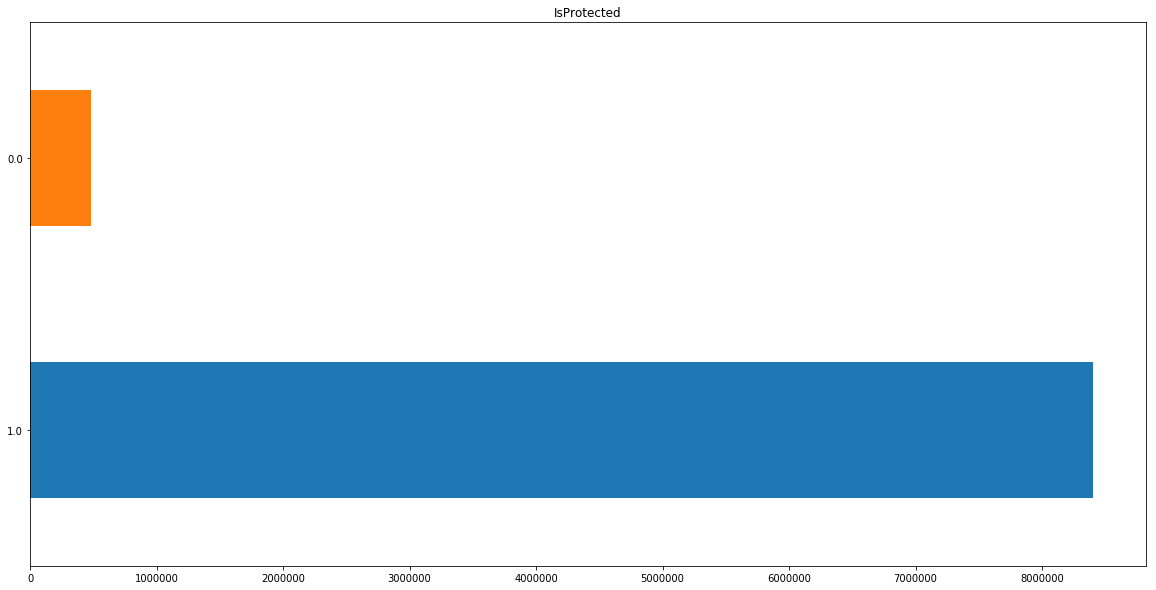

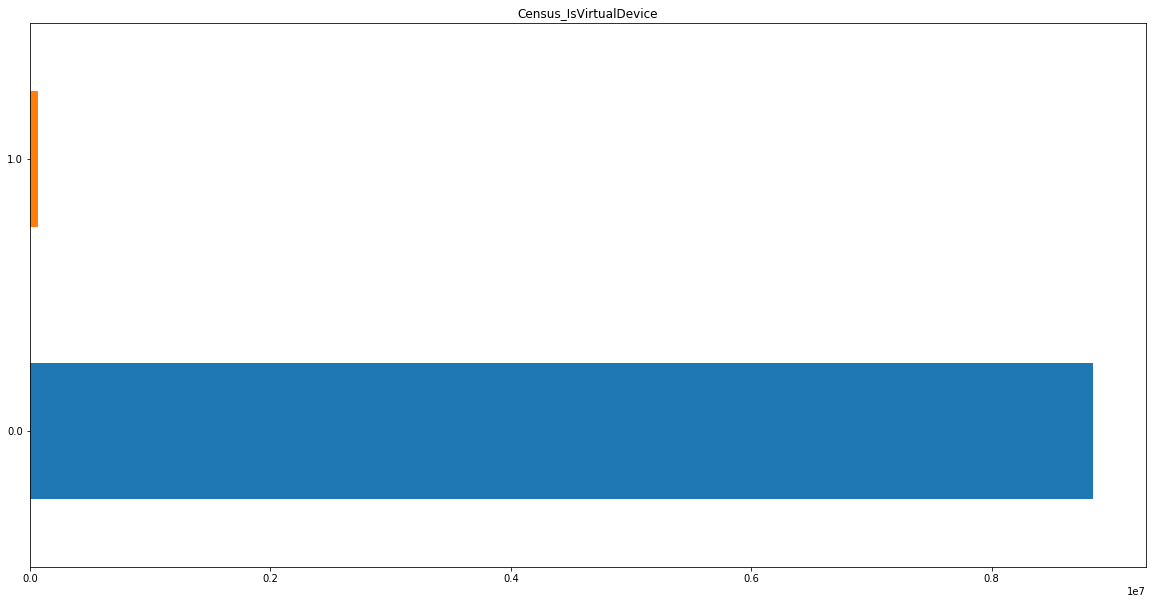

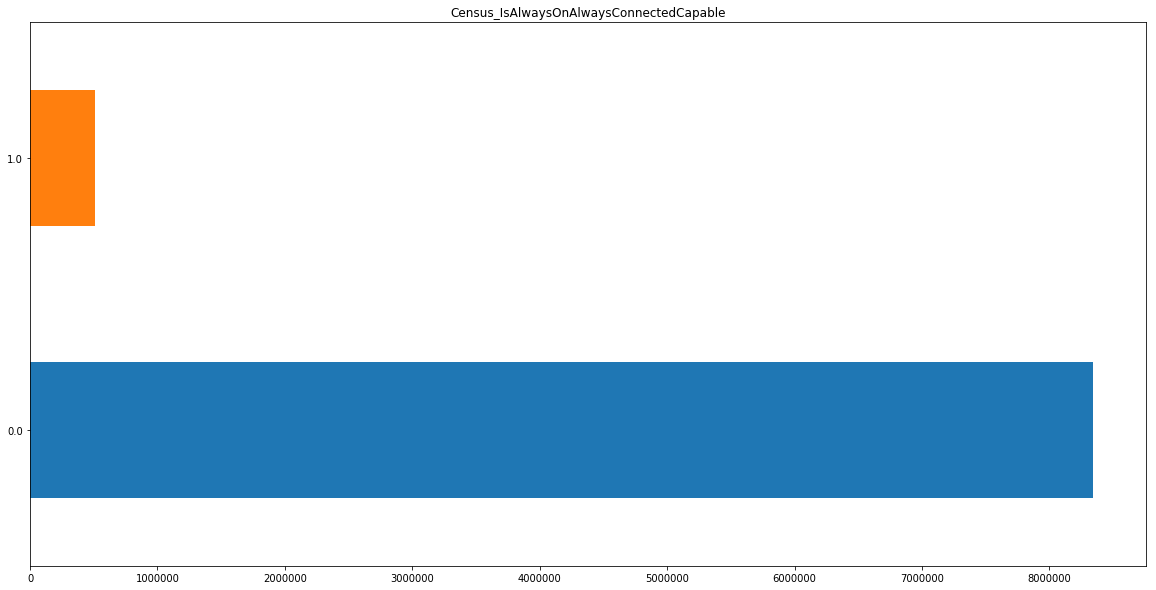

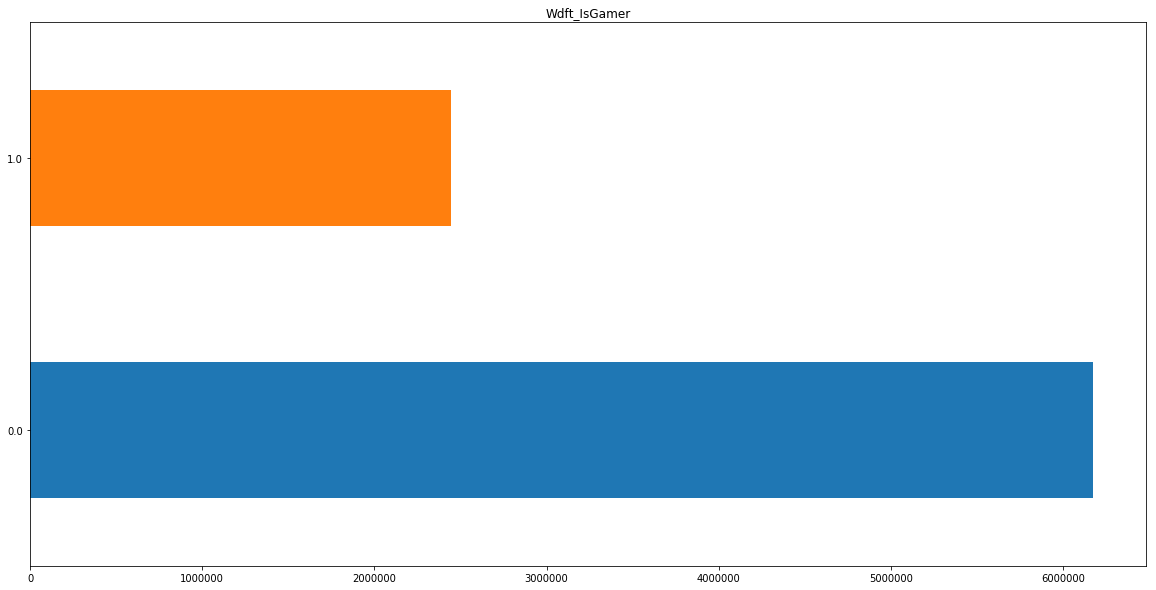

In [21]:
import matplotlib.pyplot as plt

for i, col in enumerate(correlated_cols):
    #count = train_data[col].value_counts(sort=False).sort_values(ascending=False).nlargest(50)
    plt.figure(i)
    train_df[col].value_counts(sort=False).sort_values(ascending=False).nlargest(50).plot(kind='barh', figsize=(20,10), title=col)
    #sns.set(style="darkgrid")
    #sns.barplot(count.index, count.values, alpha=0.9)
    #plt.hist(x=count)
    #plt.figsize=[20,10]
    #plt.title('Frequency Distribution of ' + col )
    #plt.ylabel('Number of Occurrences', fontsize=12)
    #plt.xlabel(col, fontsize=12)
    #plt.show()
    
#    


In [22]:
# function to create new train, test and dev samples pulling data from the training set using random stratification on the outcome variable
from sklearn.model_selection import train_test_split
def generate_train_test_dev_minis(n, features, labels):
    sample_size = n / features.shape[0]
    reserved_size = 1-sample_size
    X_train, X_test_and_dev_and_rest, y_train, y_test_and_dev_and_rest = train_test_split(features, labels, stratify=labels, test_size=reserved_size, random_state=0)
    reserved_size = 1-X_train.shape[0]/X_test_and_dev_and_rest.shape[0]
    X_test, X_dev_and_rest, y_test, y_dev_and_rest = train_test_split(X_test_and_dev_and_rest, y_test_and_dev_and_rest, stratify=y_test_and_dev_and_rest, test_size=reserved_size, random_state=0)
    reserved_size = 1-X_test.shape[0]/X_dev_and_rest.shape[0]
    X_dev, X_rest, y_dev, y_rest = train_test_split(X_dev_and_rest, y_dev_and_rest, stratify=y_dev_and_rest, test_size=reserved_size, random_state=0)
    return X_train, X_test, X_dev, y_train, y_test, y_dev

In [23]:
X_train, X_test, X_dev, y_train, y_test, y_dev = generate_train_test_dev_minis(50000, train_data_corr, train_labels)

In [24]:
print(X_train.shape)
print(X_test.shape)
print(X_dev.shape)

(50000, 11)
(50000, 11)
(50000, 11)


In [25]:
classifier =  KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='uniform')

In [26]:
pred_y = classifier.predict(X_test)

In [27]:
results = confusion_matrix(y_test, pred_y)
error = zero_one_loss(y_test, pred_y)

print(results)
print(error)

[[19234  5776]
 [16555  8435]]
0.44662


In [28]:
# scratch area below

In [29]:
#fsel = ske.ExtraTreesClassifier().fit(train_data_corr, train_labels)
#model = SelectFromModel(fsel, prefit=True)
#train_data_new = model.transform(train_data_corr)
#nb_features = train_data_new.shape[1]
#nb_features
#train_data_new